In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from scipy.interpolate import interp1d
import time

In [1]:
def MAKE_POS_MATRIX(pos):
    x,y,z = pos[0], pos[1], pos[2]
    X = np.zeros((N,N))
    Y = np.zeros((N,N))
    Z = np.zeros((N,N))
    for i in range(N):
        X[i] = np.roll(x,-i)
        Y[i] = np.roll(y,-i)
        Z[i] = np.roll(z,-i)
    return np.vstack((np.expand_dims(X,axis=0),np.expand_dims(Y,axis=0),np.expand_dims(Z,axis=0)))

def MAKE_MASS_MATRIX(mass):
    M = np.zeros((N,N))
    for i in range(N):
        M[i] = np.roll(mass,-i)
    return M
        
def GET_ACCELERATION(X,M):
    pos = np.expand_dims(X[:,:,0],axis=2)
    return ((((X[:,:,1:]-pos)**2).sum(axis=0))**-1.5*M[:,1:]*(X[:,:,1:]-pos)).sum(axis=2)

def DKD_SCHEME(pos,vel,M,dt):
    pos += vel*0.5*dt
    X = MAKE_POS_MATRIX(pos)
    A = GET_ACCELERATION(X,M)
    vel += A*dt
    pos += vel*0.5*dt
    X = MAKE_POS_MATRIX(pos)
    energy = GET_ENERGY(X,M,vel,mass)
    return pos, vel, energy

def KDK_SCHEME(pos,vel,M,A,dt):
    vel += A*0.5*dt
    pos += vel*dt
    X = MAKE_POS_MATRIX(pos)
    A = GET_ACCELERATION(X,M)
    vel += A*0.5*dt
    energy = GET_ENERGY(X,M,vel,mass)
    return pos, vel, A, energy

def RK4_SCHEME(pos,vel,M,X,A,dt):
    k_1_vel = A
    k_1_pos = vel
    X = MAKE_POS_MATRIX(pos+k_1_pos*dt/2.)
    k_2_vel = GET_ACCELERATION(X,M)
    k_2_pos = vel + k_1_vel*dt/2.
    X = MAKE_POS_MATRIX(pos+k_2_pos*dt/2.)
    k_3_vel = GET_ACCELERATION(X,M)
    k_3_pos = vel + k_2_vel*dt/2.
    X = MAKE_POS_MATRIX(pos+k_3_pos*dt)
    k_4_vel = GET_ACCELERATION(X,M)
    k_4_pos = vel + k_3_vel*dt
    pos += dt/6.*(k_1_pos+2.*k_2_pos+2.*k_3_pos+k_4_pos)
    vel += dt/6.*(k_1_vel+2.*k_2_vel+2.*k_3_vel+k_4_vel)
    X = MAKE_POS_MATRIX(pos)
    A = GET_ACCELERATION(X,M)
    energy = GET_ENERGY(X,M,vel,mass)
    return pos, vel, X, A, energy

def GET_ENERGY(X,M,vel,mass):
    kinetic = (mass*vel**2).sum()
    pos = np.expand_dims(X[:,:,0],axis=2)
    potential = -(((M[:,1:]*(((X[:,:,1:]-pos)**2).sum(axis=0))**-0.5).sum(axis=1))*mass).sum()
    return 0.5*(kinetic + potential)

def GET_ERROR(pos,pos_analytic):
    error_pos = (((pos-pos_analytic)**2).mean()/(pos_analytic**2).mean())**0.5
    return error_pos

def GET_ANALYTIC_RESULT(t,A):
    if A>=1.:
        pos_analytic = INTERPOLATE(theta,T,t)
    else:
        pos_analytic = INTERPOLATE(theta,T,t-T_half*2*(t//(T_half*2)))
    return pos_analytic

def PLOTTING(pos_analytic, pos,vel,error_energy):   
    display.clear_output(wait=True)
    plt.cla()
    plt.plot(x_1_analytic, y_1_analytic, lw = 1.25, color='red', ls='--', alpha=0.7, label='Traj. of $m_1$')
    plt.plot(x_2_analytic, y_2_analytic, lw = 1.25, color='k', ls='--', alpha=0.7, label='Traj. of $m_2$')
    plt.scatter(pos[0][0], pos[1][0], s=30.0, color='blue', label='%s Pos. of $m_1$'%mode)
    plt.scatter(pos[0][1], pos[1][1], s=30.0, color='lime', label='%s Pos. of $m_2$'%mode)
    plt.scatter(pos_analytic[0][0], pos_analytic[1][0], s=30.0, color='gold', marker='*',\
                label='%s Pos. of $m_1$'%mode)
    plt.scatter(pos_analytic[0][1], pos_analytic[1][1], s=30.0, color='pink', marker='*',\
                label='%s Pos. of $m_2$'%mode)
    plt.xlim(x_min*1.1, x_max*1.1)
    plt.xticks(np.linspace(x_min,x_max,5))
    plt.ylim(y_min*1.1, y_max*1.1)
    plt.yticks(np.linspace(y_min,y_max,5))
    plt.title("Time = %.3f $2\pi/\omega$\nError of Energy = %.4e"%(t/period, error_energy),fontsize=10.)
    lgnd=plt.legend(loc='upper right', prop={'size':3.5})
    lgnd.legendHandles[2]._sizes = [4]
    lgnd.legendHandles[3]._sizes = [4]
    lgnd.legendHandles[4]._sizes = [4]
    lgnd.legendHandles[5]._sizes = [4]
    display.display(plt.gcf())
    time.sleep(0.01)

# def PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy):
#     display.clear_output(wait=True)
#     plt.cla()
#     plt.plot(XX, YY, lw = 1.25, color='red', ls='--', alpha=0.7)
#     q1 = plt.quiver(pos_analytic[0],pos_analytic[1],vel_analytic[0],vel_analytic[1], color='k', scale=10.0)
#     plt.quiverkey(q1, 0.87,0.05,1.,'Analytic Vel.', fontproperties={'size':6.0}, labelsep=0.05)
#     q2 = plt.quiver(pos[0],pos[1],vel[0],vel[1], color='lime', scale=10.0)
#     plt.quiverkey(q2, 0.87,0.15,1.,'%s Vel.'%mode, fontproperties={'size':6.0}, labelsep=0.05)
#     plt.scatter(pos[0], pos[1], s=50.0, color='blue', label='%s Pos.'%mode)
#     plt.scatter(pos_analytic[0], pos_analytic[1], s=50.0, color='gold', label='Analytic Pos.', alpha=0.6, marker="*")
#     plt.xlim(-1.35, 1.35)
#     plt.xticks(np.linspace(-1.0,1.0,5))
#     plt.ylim(-1.35, 1.35)
#     plt.yticks(np.linspace(-1.0,1.0,5))
#     plt.title("Time = %.3f Period\nError of Energy = %.4e"%(t/period, error_energy),fontsize=10.)
#     lgnd=plt.legend(loc='upper right', prop={'size':5.5})
#     lgnd.legendHandles[0]._sizes = [10]
#     lgnd.legendHandles[1]._sizes = [10]
#     display.display(plt.gcf())
#     time.sleep(0.01)

def F_PARABOLIC(x):
    return np.sin(x)*(np.cos(x)+2.)/3./(np.cos(x)+1.)**2

def F_HYPERBOLIC(x,A):
    return A*np.sin(x)/(A**2-1.)/(A*np.cos(x)+1.)-2.*np.arctanh((A-1.)*np.tan(x/2.)/(A**2-1)**0.5)/(A**2-1.)**1.5

def F_ELLIPSE(x,A):
    return (A*np.sin(x)/(A**2-1.)/(A*np.cos(x)+1.)-2.*np.arctanh((A-1.)*np.tan(x/2.)/(A**2-1.)**0.5)/(A**2-1.)**1.5).real

def INTERPOLATE(theta, t, t_selected):
    theta_to_t = interp1d(t, theta, kind='cubic')
    theta_selected = np.float(theta_to_t(t_selected))
    r = L**2/M_total/M_reduce**2/(1.+A*np.cos(theta_selected))
    x_analytic = r/M_total*np.array([np.cos(theta_selected)*m2, -np.cos(theta_selected)*m1])
    y_analytic = r/M_total*np.array([np.sin(theta_selected)*m2, -np.sin(theta_selected)*m1])
    pos_analytic = np.vstack((x_analytic,y_analytic, np.zeros(2)))
    return pos_analytic

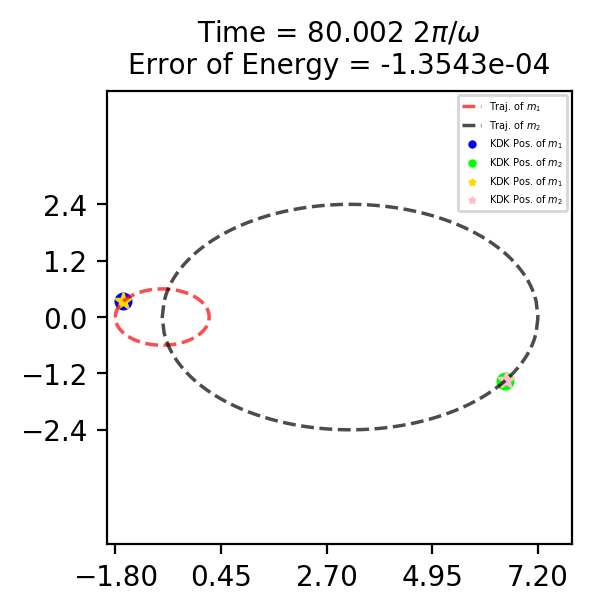

In [36]:
N = 2
r = 1.0
m1, m2 = 4., 1.0
M_total = m1+m2
M_reduce = m1*m2/(m1+m2)
A = 0.8
L = ((1.+A)*r*M_total*M_reduce**2)**0.5
omega = L/M_reduce/r**2
period = 2.*np.pi/omega

x = r/M_total*np.array([m2, -m1])
y = np.zeros(2)
z = np.zeros(2)
pos = np.vstack((x,y,z))
X = MAKE_POS_MATRIX(pos)

vx = np.zeros(2)
vy = omega*x
vz = np.zeros(2)
vel = np.vstack((vx,vy,vz))

mass = np.array([m1,m2])
M = MAKE_MASS_MATRIX(mass)

if A==1.:    
#     R = L**2/M_total/M_reduce**2/(1.+np.cos(theta))
#     x = R*np.cos(theta)
#     y = R*np.sin(theta)
#     plt.scatter(x,y)
    
    c = L**2/2./M_total/M_reduce**2
    x_f = c
    x_prime = x_f + np.linspace(-100*c,0,400)
    y_prime = (abs(4.*c*(x_prime-x_f)))**0.5
    x_prime = np.hstack((x_prime,np.flip(x_prime)))
    y_prime = np.hstack((y_prime,np.flip(-y_prime)))
    theta = np.linspace(0,np.pi*0.95,400)
    T = L**3/M_total**2/M_reduce**3*F_PARABOLIC(theta)
    
elif A<1.0:
#     R = L**2/M_total/M_reduce**2/(1.+A*np.cos(theta))
#     x = R*np.cos(theta)
#     y = R*np.sin(theta)
#     plt.scatter(x,y)
    
    x_f = -A*L**2/M_total/M_reduce**2/(1.-A**2)
    a = L**2/(1.-A**2)/M_total/M_reduce**2
    b = L**2/(1.-A**2)**0.5/M_total/M_reduce**2
    x_prime = x_f + np.linspace(-a,a,200)
    y_prime = b*(abs(1.-((x_prime-x_f)/a)**2))**0.5
    x_prime = np.hstack((x_prime,np.flip(x_prime)))
    y_prime = np.hstack((y_prime,np.flip(-y_prime)))
    theta = np.linspace(0.,2.*np.pi,200)
    T = np.zeros_like(theta)
    T[:len(theta)//2] = L**3/M_total**2/M_reduce**3*F_ELLIPSE(theta[:len(theta)//2], A)
    T_half = 2.*np.pi*a*b*M_reduce/L*0.5
    T[len(theta)//2:] = 2.*T_half-np.flip(T[:len(theta)//2])
    
else:
#     R = L**2/M_total/M_reduce**2/(1.+A*np.cos(theta))
#     x = R*np.cos(theta)
#     y = R*np.sin(theta)
#     plt.scatter(x,y)
    
    x_f = A*L**2/M_total/M_reduce**2/(A**2-1.)
    a = L**2/(A**2-1.)/M_total/M_reduce**2
    b = L**2/(A**2-1.)**0.5/M_total/M_reduce**2
    x_prime = x_f + np.linspace(-50*a,-a,200)
    y_prime = b*(abs(1.-((x_prime-x_f)/a)**2))**0.5
    x_prime = np.hstack((x_prime,np.flip(x_prime)))
    y_prime = np.hstack((y_prime,np.flip(-y_prime)))
    theta = np.linspace(-np.arccos(-1./A)*0.9999,np.arccos(-1./A)*0.9999,400)
    T = L**3/M_total**2/M_reduce**3*F_HYPERBOLIC(theta,A)
    
x_1_analytic = x_prime*m2/M_total
y_1_analytic = y_prime*m2/M_total
x_2_analytic = -x_prime*m1/M_total
y_2_analytic = -y_prime*m1/M_total

x_min = min(x_1_analytic.min(), x_2_analytic.min())
x_max = max(x_1_analytic.max(), x_2_analytic.max())
y_min = min(y_1_analytic.min(), y_2_analytic.min())
y_max = max(y_1_analytic.max(), y_2_analytic.max())

dt = 5e-3
t = 0.0
index, drawing_resolution = 0, 100
end_t = 80.0*period
mode = 'KDK'
t_record = []
energy_record = []
energy_analytic = GET_ENERGY(X,M,vel,mass)

plt.figure(figsize=(3,3), dpi=200)
plt.axis('equal')

if mode == 'KDK':
#     X = MAKE_POS_MATRIX(pos)
    acc = GET_ACCELERATION(X,M)
    while t<end_t:
        pos, vel, acc,energy = KDK_SCHEME(pos,vel,M,acc,dt)
        t += dt
        t_record.append(t)
        if energy_analytic!=0:
            error_energy = (energy-energy_analytic)/energy_analytic
        else:
            error_energy = energy-energy_analytic
        energy_record.append(error_energy)
        if index%drawing_resolution == 0:
            pos_analytic = GET_ANALYTIC_RESULT(t,A)
#             PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
            PLOTTING(pos_analytic,pos,vel,error_energy)
#         if abs(t-2.5*period)<1e-3:
#             plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW5/snap_shoot_Kepler_A=%2f_mode=%s.png"\
#                         %(A,mode), bbox_inches='tight', dpi=320, pad_inches=0.05)
        index += 1
elif mode == 'DKD':
    while t<end_t:
        pos, vel,energy = DKD_SCHEME(pos,vel,M,dt)
        t += dt
        t_record.append(t)
        if energy_analytic!=0:
            error_energy = (energy-energy_analytic)/energy_analytic
        else:
            error_energy = energy-energy_analytic
        energy_record.append(error_energy)
        if index%drawing_resolution == 0:
            pos_analytic = GET_ANALYTIC_RESULT(t,A)
#             PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
            PLOTTING(pos_analytic,pos,vel,error_energy)
    
        index += 1
elif mode == 'RK4':
    acc = GET_ACCELERATION(X,M)
    while t<end_t:
        pos, vel, X, acc, energy = RK4_SCHEME(pos,vel,M,X,acc,dt)
        t += dt
        t_record.append(t)
        if energy_analytic!=0:
            error_energy = (energy-energy_analytic)/energy_analytic
        else:
            error_energy = energy-energy_analytic
        energy_record.append(error_energy)
        if index%drawing_resolution == 0:
            pos_analytic = GET_ANALYTIC_RESULT(t,A)
#             PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
            PLOTTING(pos_analytic,pos,vel,error_energy)
        index += 1

t_record = np.array(t_record)
t_record /= period
energy_record = np.array(energy_record)
pos_analytic = GET_ANALYTIC_RESULT(t, A)
PLOTTING(pos_analytic,pos,vel,energy_record[-1])
display.clear_output(wait=True)

In [4]:
error_pos = GET_ERROR(pos, pos_analytic)
print("Error of position is %.8e ; error of energy is %.8e ."%(error_pos,energy_record[-1]))

Error of position is 7.73688873e-03 ; error of energy is -5.41799061e-04 .


In [5]:
print(pos, pos_analytic)

[[-1.61883897  6.47535589]
 [ 0.3464985  -1.38599398]
 [ 0.          0.        ]] [[-1.6274356   6.50974239]
 [ 0.33693637 -1.34774549]
 [ 0.          0.        ]]


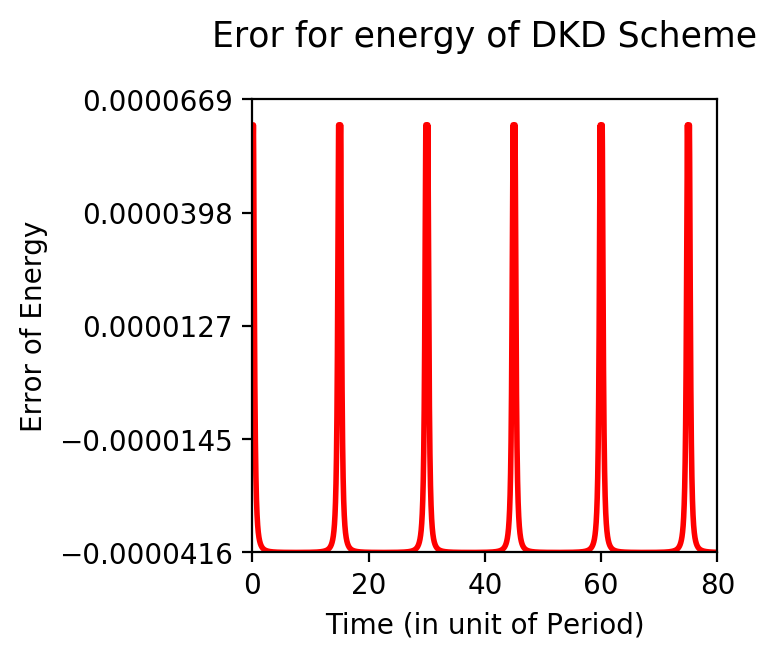

In [11]:
plt.figure(figsize=(3,3), dpi=200)
plt.plot(t_record, energy_record, lw=2.0, c='red')
plt.xlim([0,end_t/period])
plt.ylim([energy_record.min(),1.1*energy_record.max()])
plt.yticks(np.linspace(energy_record.min(),1.1*energy_record.max(),5))
plt.xlabel("Time (in unit of Period)")
plt.ylabel("Error of Energy")
plt.title("Eror for energy of %s Scheme"%mode, y=1.08, fontsize=12.5)
plt.show()

	dt = 0.00500, error min:3.12460946e-08; error max:6.73630965e-05


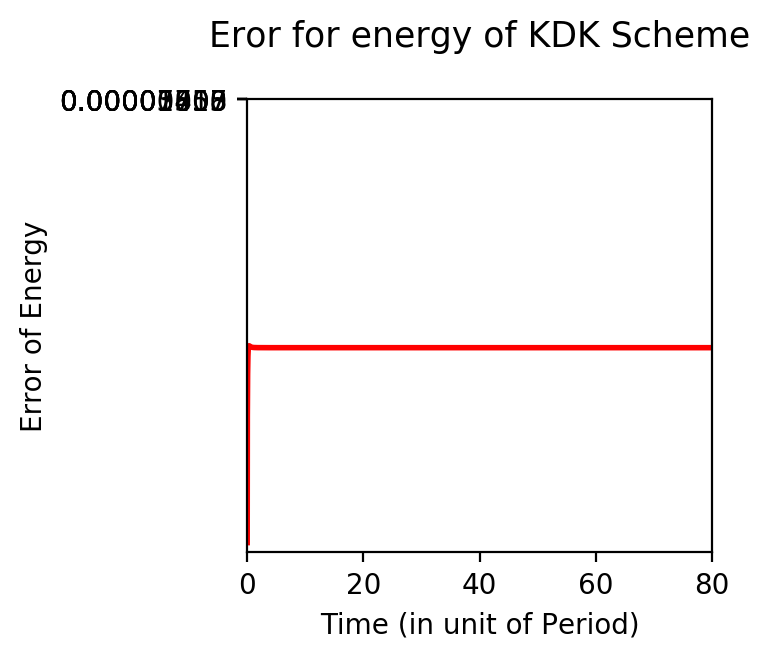

In [19]:
plt.figure(figsize=(3,3), dpi=200)
criteria = abs(energy_record)>=1e-16
plt.plot(t_record[criteria], np.log10(abs(energy_record[criteria])), lw=2.0, c='red')
plt.xlim([0,end_t/period])
# plt.ylim([energy_record.min(),1.1*energy_record.max()])
plt.yticks(np.linspace(energy_record.min(),1.1*energy_record.max(),5))
plt.xlabel("Time (in unit of Period)")
plt.ylabel("Error of Energy")
plt.title("Eror for energy of %s Scheme"%mode, y=1.08, fontsize=12.5)
print("\tdt = %.5f, error min:%.8e; error max:%.8e"%(dt,energy_record[criteria].min(),energy_record[criteria].max()))
plt.show()

In [21]:
import os

Folder already existed!
dt = 8.000000e-02:
	Error of position is 3.82870230e-03 ; error of energy is -4.33234504e-05 .
dt = 4.000000e-02:
	Error of position is 9.75579744e-04 ; error of energy is -2.67659525e-06 .
dt = 2.000000e-02:
	Error of position is 2.45211974e-04 ; error of energy is -1.66861262e-07 .
dt = 1.000000e-02:
	Error of position is 6.15322762e-05 ; error of energy is -1.04300225e-08 .
dt = 5.000000e-03:
	Error of position is 1.56023216e-05 ; error of energy is -6.53827423e-10 .
dt = 2.500000e-03:
	Error of position is 4.33194933e-06 ; error of energy is -4.13624412e-11 .
dt = 1.250000e-03:
	Error of position is 1.98620722e-06 ; error of energy is -2.72658979e-12 .


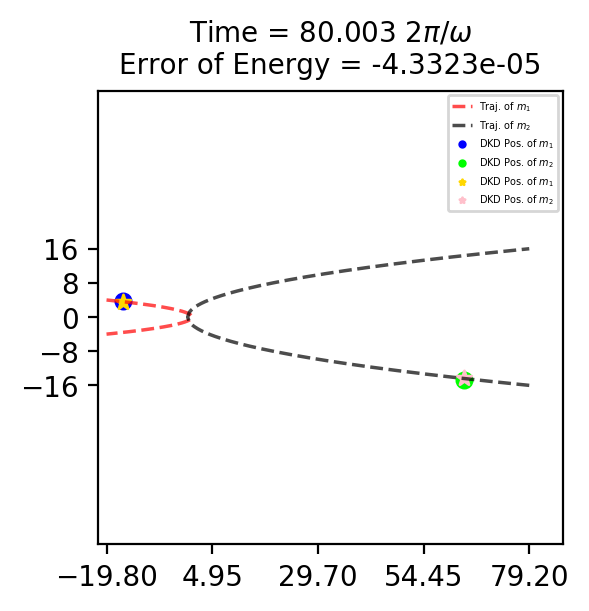

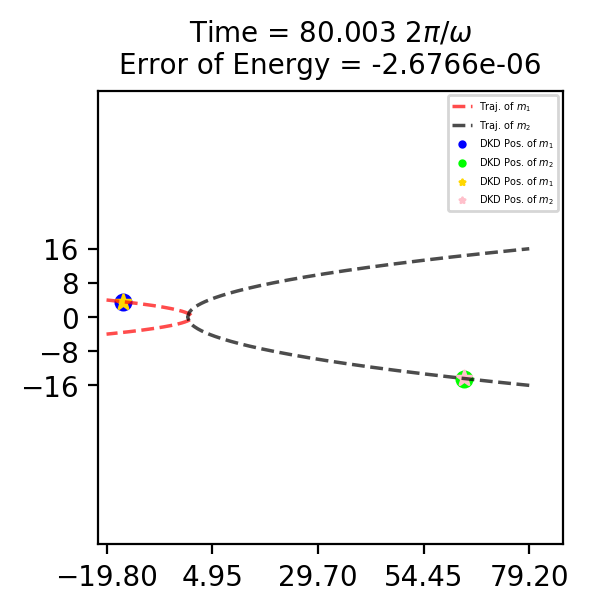

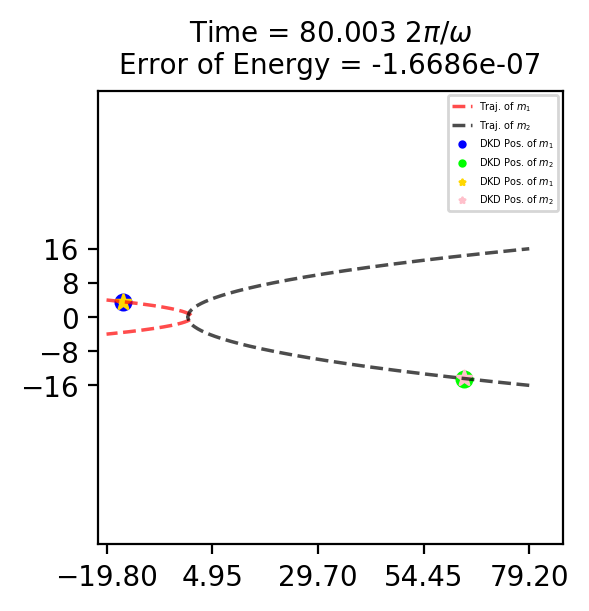

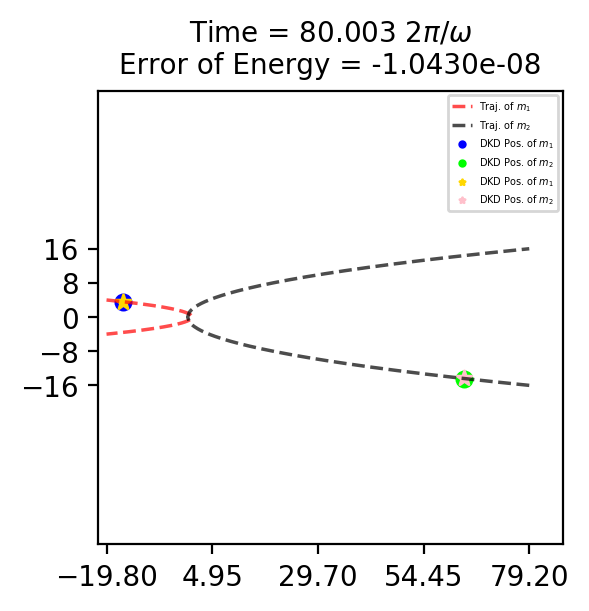

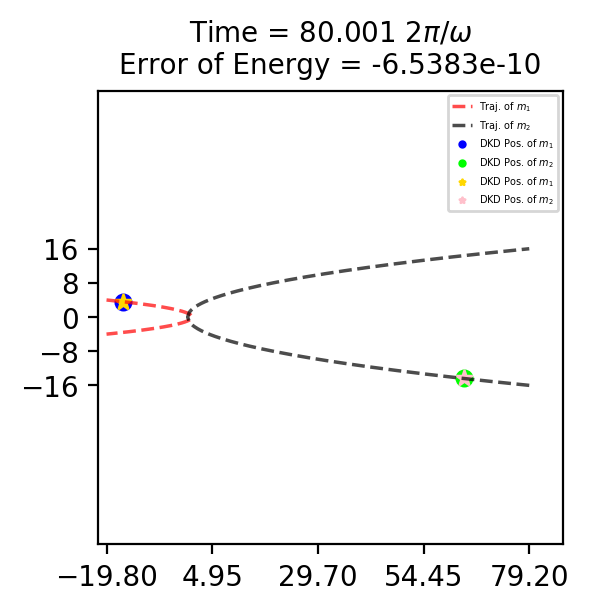

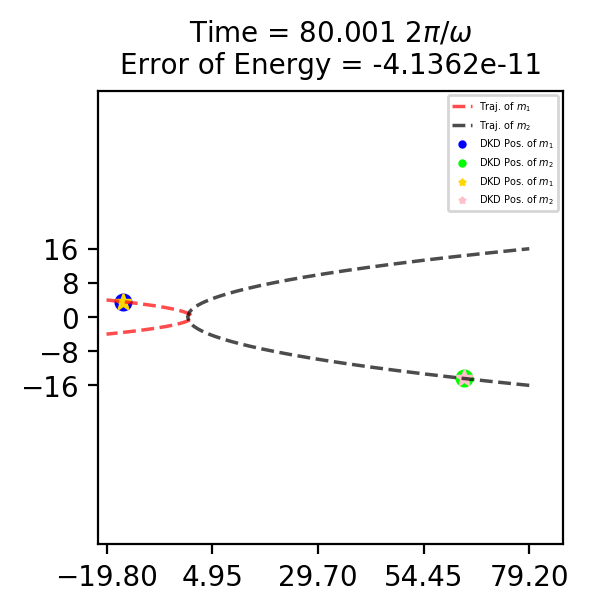

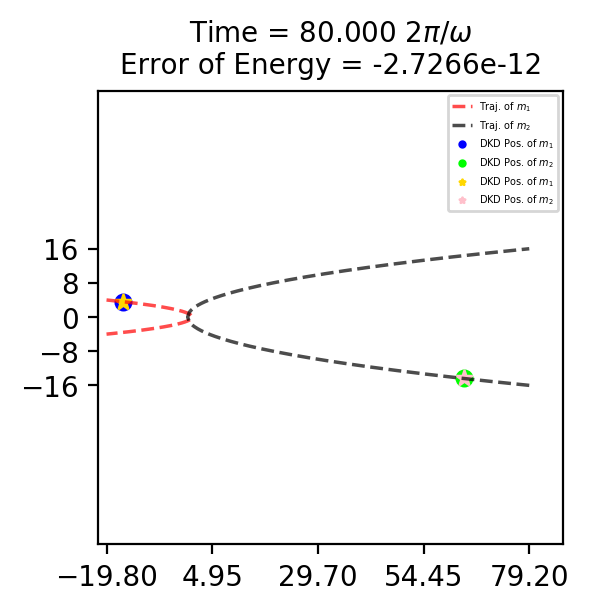

In [32]:
N = 2
r = 1.0
m1, m2 = 4., 1.0
A = 1.0
mode = 'DKD'

mass = np.array([m1,m2])
M = MAKE_MASS_MATRIX(mass)
M_total = m1+m2
M_reduce = m1*m2/(m1+m2)
L = ((1.+A)*r*M_total*M_reduce**2)**0.5
omega = L/M_reduce/r**2
period = 2.*np.pi/omega
end_t = 80.0*period
x = r/M_total*np.array([m2, -m1])
y = np.zeros(2)
z = np.zeros(2)
vx = np.zeros(2)
vy = omega*x
vz = np.zeros(2)

pos_error_record = []
energy_error_record = []

if A==1.:    
#     R = L**2/M_total/M_reduce**2/(1.+np.cos(theta))
#     x = R*np.cos(theta)
#     y = R*np.sin(theta)
#     plt.scatter(x,y)
    
    c = L**2/2./M_total/M_reduce**2
    x_f = c
    x_prime = x_f + np.linspace(-100*c,0,200)
    y_prime = (abs(4.*c*(x_prime-x_f)))**0.5
    x_prime = np.hstack((x_prime,np.flip(x_prime)))
    y_prime = np.hstack((y_prime,np.flip(-y_prime)))
    theta = np.linspace(0,np.pi*0.95,400)
    T = L**3/M_total**2/M_reduce**3*F_PARABOLIC(theta)
    
elif A<1.0:
#     R = L**2/M_total/M_reduce**2/(1.+A*np.cos(theta))
#     x = R*np.cos(theta)
#     y = R*np.sin(theta)
#     plt.scatter(x,y)
    
    x_f = -A*L**2/M_total/M_reduce**2/(1.-A**2)
    a = L**2/(1.-A**2)/M_total/M_reduce**2
    b = L**2/(1.-A**2)**0.5/M_total/M_reduce**2
    x_prime = x_f + np.linspace(-a,a,200)
    y_prime = b*(abs(1.-((x_prime-x_f)/a)**2))**0.5
    x_prime = np.hstack((x_prime,np.flip(x_prime)))
    y_prime = np.hstack((y_prime,np.flip(-y_prime)))
    theta = np.linspace(0.,2.*np.pi,200)
    T = np.zeros_like(theta)
    T[:len(theta)//2] = L**3/M_total**2/M_reduce**3*F_ELLIPSE(theta[:len(theta)//2], A)
    T_half = 2.*np.pi*a*b*M_reduce/L*0.5
    T[len(theta)//2:] = 2.*T_half-np.flip(T[:len(theta)//2])
    
else:
#     R = L**2/M_total/M_reduce**2/(1.+A*np.cos(theta))
#     x = R*np.cos(theta)
#     y = R*np.sin(theta)
#     plt.scatter(x,y)
    
    x_f = A*L**2/M_total/M_reduce**2/(A**2-1.)
    a = L**2/(A**2-1.)/M_total/M_reduce**2
    b = L**2/(A**2-1.)**0.5/M_total/M_reduce**2
    x_prime = x_f + np.linspace(-50*a,-a,200)
    y_prime = b*(abs(1.-((x_prime-x_f)/a)**2))**0.5
    x_prime = np.hstack((x_prime,np.flip(x_prime)))
    y_prime = np.hstack((y_prime,np.flip(-y_prime)))
    theta = np.linspace(-np.arccos(-1./A)*0.9999,np.arccos(-1./A)*0.9999,400)
    T = L**3/M_total**2/M_reduce**3*F_HYPERBOLIC(theta,A)
    
x_1_analytic = x_prime*m2/M_total
y_1_analytic = y_prime*m2/M_total
x_2_analytic = -x_prime*m1/M_total
y_2_analytic = -y_prime*m1/M_total

x_min = min(x_1_analytic.min(), x_2_analytic.min())
x_max = max(x_1_analytic.max(), x_2_analytic.max())
y_min = min(y_1_analytic.min(), y_2_analytic.min())
y_max = max(y_1_analytic.max(), y_2_analytic.max())

path = "./Data_Saving/Kepler_Orbit/A=%.4f_end_t=%.fperiod/"%(A,end_t/period)
try:
    os.makedirs(path)
except:
    print("Folder already existed!")

# if mode!='RK4':
#     dt_range = np.array([8e-2,4e-2,2e-2,1e-2,5e-3,2.5e-3,1.25e-3])
# else:
#     dt_range = np.array([8e-1,4e-1,2e-1,1e-1,5e-2,2.5e-2,1.25e-2])
dt_range = np.array([8e-2,4e-2,2e-2,1e-2,5e-3,2.5e-3,1.25e-3])

for dt in dt_range:
    t = 0.0
    pos = np.vstack((x,y,z))
    vel = np.vstack((vx,vy,vz))
    X = MAKE_POS_MATRIX(pos)
    energy_analytic = GET_ENERGY(X,M,vel,mass)
    t_record = []
    energy_record = []
    pos_record = []

    if mode == 'KDK':
    #     X = MAKE_POS_MATRIX(pos)
        acc = GET_ACCELERATION(X,M)
        while t<end_t:
            pos, vel, acc,energy = KDK_SCHEME(pos,vel,M,acc,dt)
            t += dt
            t_record.append(t)
            if energy_analytic!=0:
                error_energy = (energy-energy_analytic)/energy_analytic
            else:
                error_energy = energy-energy_analytic
            energy_record.append(error_energy)
            pos_analytic = GET_ANALYTIC_RESULT(t,A)
            error_pos = GET_ERROR(pos, pos_analytic)
            pos_record.append(error_pos)
    elif mode == 'DKD':
        while t<end_t:
            pos, vel,energy = DKD_SCHEME(pos,vel,M,dt)
            t += dt
            t_record.append(t)
            if energy_analytic!=0:
                error_energy = (energy-energy_analytic)/energy_analytic
            else:
                error_energy = energy-energy_analytic
            energy_record.append(error_energy)
            pos_analytic = GET_ANALYTIC_RESULT(t,A)
            error_pos = GET_ERROR(pos, pos_analytic)
            pos_record.append(error_pos)
    elif mode == 'RK4':
        acc = GET_ACCELERATION(X,M)
        while t<end_t:
            pos, vel, X, acc, energy = RK4_SCHEME(pos,vel,M,X,acc,dt)
            t += dt
            t_record.append(t)
            if energy_analytic!=0:
                error_energy = (energy-energy_analytic)/energy_analytic
            else:
                error_energy = energy-energy_analytic
            energy_record.append(error_energy)
            pos_analytic = GET_ANALYTIC_RESULT(t,A)
            error_pos = GET_ERROR(pos, pos_analytic)
            pos_record.append(error_pos)

    t_record = np.array(t_record)
    t_record /= period
    energy_record = np.array(energy_record)
    pos_record = np.array(pos_record)
    pos_analytic = GET_ANALYTIC_RESULT(t, A)
    error_pos = GET_ERROR(pos, pos_analytic)
    print("dt = %.6e:"%dt)
    print("\tError of position is %.8e ; error of energy is %.8e ."%(error_pos,energy_record[-1]))
    pos_error_record.append(error_pos)
    energy_error_record.append(energy_record[-1])

    plt.figure(figsize=(3,3), dpi=200)
    plt.axis('equal')
    plt.plot(x_1_analytic, y_1_analytic, lw = 1.25, color='red', ls='--', alpha=0.7, label='Traj. of $m_1$')
    plt.plot(x_2_analytic, y_2_analytic, lw = 1.25, color='k', ls='--', alpha=0.7, label='Traj. of $m_2$')
    plt.scatter(pos[0][0], pos[1][0], s=30.0, color='blue', label='%s Pos. of $m_1$'%mode)
    plt.scatter(pos[0][1], pos[1][1], s=30.0, color='lime', label='%s Pos. of $m_2$'%mode)
    plt.scatter(pos_analytic[0][0], pos_analytic[1][0], s=30.0, color='gold', marker='*',\
                label='%s Pos. of $m_1$'%mode)
    plt.scatter(pos_analytic[0][1], pos_analytic[1][1], s=30.0, color='pink', marker='*',\
                label='%s Pos. of $m_2$'%mode)
    plt.xlim(x_min*1.1, x_max*1.1)
    plt.xticks(np.linspace(x_min,x_max,5))
    plt.ylim(y_min*1.1, y_max*1.1)
    plt.yticks(np.linspace(y_min,y_max,5))
    plt.title("Time = %.3f $2\pi/\omega$\nError of Energy = %.4e"%(t/period, error_energy),fontsize=10.)
    lgnd=plt.legend(loc='upper right', prop={'size':3.5})
    lgnd.legendHandles[2]._sizes = [4]
    lgnd.legendHandles[3]._sizes = [4]
    lgnd.legendHandles[4]._sizes = [4]
    lgnd.legendHandles[5]._sizes = [4]

    with open(path+"mode=%s_dt=%s.txt"%(mode,dt),"w") as file:
        file.write("#\tTime\tError_of_Energy\tError_of_Position\n")
        np.savetxt(file, np.vstack((t_record,energy_record, pos_record)).T, fmt='%.8e')
        file.close()

pos_error_record = np.array(pos_error_record)
energy_error_record = np.array(energy_error_record)        
with open(path+"mode=%s_pos_error.txt"%mode,"w") as file:
    file.write("#\tdt\tError_of_Position\tError_of_Energy\n")
    np.savetxt(file, np.vstack((dt_range,pos_error_record,energy_error_record)).T, fmt='%.8e')
    file.close()